In [62]:
import wandb
import datetime
from argparse import Namespace
wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [63]:
import numpy as np
import pandas as pd
import random


# model interpretability
from captum.attr import IntegratedGradients

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transform
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image, ImageFile
import copy
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [64]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

In [65]:
config=Namespace(
    project_name="VGG19_TRANSFORMER_twoimage",
    batch_size = 16,
    epochs = 150,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    criterion = nn.CrossEntropyLoss()
    )
    
print(config.device)

cuda


In [66]:
root_dir="./data/Thermal Camera Images" #480x640 "..":表上級目錄
thermal=[]
label=["NoGas","Perfume","Smoke","Mixture"]

for i, cls in enumerate(label):
    # print(cls)
    class_dir = os.path.join(root_dir, cls)
    class_image=[f for f in os.listdir(class_dir)]
    class_image = sorted(class_image, key=lambda x: int(x.split("_")[0]))
    for img in class_image:
        thermal.append((os.path.join(class_dir, img), i))

thermal = np.array(thermal)

print(thermal)

[['./data/Thermal Camera Images/NoGas/0_NoGas.png' '0']
 ['./data/Thermal Camera Images/NoGas/1_NoGas.png' '0']
 ['./data/Thermal Camera Images/NoGas/2_NoGas.png' '0']
 ...
 ['./data/Thermal Camera Images/Mixture/1597_Mixture.png' '3']
 ['./data/Thermal Camera Images/Mixture/1598_Mixture.png' '3']
 ['./data/Thermal Camera Images/Mixture/1599_Mixture.png' '3']]


In [67]:
root_dir="./data/GasImages" #480x640 "..":表上級目錄/home/server4090-3/homework_pm2.5/gas/3D/data/GasImages
gasf=[]
label=["NoGas","Perfume","Smoke","Mixture"]

for i, cls in enumerate(label):
    # print(cls)
    class_dir = os.path.join(root_dir, cls)
    class_image=[f for f in os.listdir(class_dir)]
    class_image = sorted(class_image, key=lambda x: int(x.split("_")[0]))
    for img in class_image:
        gasf.append((os.path.join(class_dir, img)))

gasf = np.array(gasf)

print(gasf.reshape(-1, 1).shape)

(6400, 1)


In [68]:

# 檢查兩個陣列的長度是否相同
assert len(thermal) == len(gasf), "兩個陣列的長度不同，無法合併。"

# 合併兩個陣列
combined_array = np.hstack((thermal, gasf.reshape(-1, 1)))
# 宣告train_id列
train_id = np.arange(len(combined_array)).reshape(-1, 1)

# 將train_id列添加到combined_array中
final_array = np.hstack((train_id,combined_array))
print(final_array)

[['0' './data/Thermal Camera Images/NoGas/0_NoGas.png' '0'
  './data/GasImages/NoGas/0_NoGas.png']
 ['1' './data/Thermal Camera Images/NoGas/1_NoGas.png' '0'
  './data/GasImages/NoGas/1_NoGas.png']
 ['2' './data/Thermal Camera Images/NoGas/2_NoGas.png' '0'
  './data/GasImages/NoGas/2_NoGas.png']
 ...
 ['6397' './data/Thermal Camera Images/Mixture/1597_Mixture.png' '3'
  './data/GasImages/Mixture/1597_Mixture.png']
 ['6398' './data/Thermal Camera Images/Mixture/1598_Mixture.png' '3'
  './data/GasImages/Mixture/1598_Mixture.png']
 ['6399' './data/Thermal Camera Images/Mixture/1599_Mixture.png' '3'
  './data/GasImages/Mixture/1599_Mixture.png']]


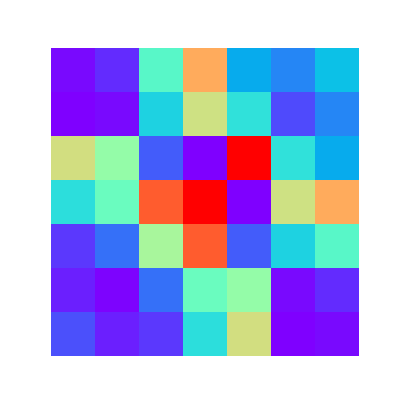

In [69]:
a='./data/GasImages/NoGas/0_NoGas.png'
b='./data/Thermal Camera Images/NoGas/0_NoGas.png'
gasf=Image.open(a).convert('RGB')
                
gasf

In [70]:
# data=pd.read_csv("../data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")
# data=data.drop("Corresponding Image Name",axis=1)
# data=data.drop("Gas",axis=1)
# # data=data.drop("Serial Number",axis=1)
# data.insert(1,"index", range(0, len(data))) #新增feature 1-6400
# data=np.array(data)

# data_cat=np.concatenate((data, file), axis=1)
# scaler = MinMaxScaler(feature_range=(0,1))
# data_cat[:,2:9]=scaler.fit_transform(data[:,2:9]) # feature 1 (1-1600)*4|feature 2 1-6400|feature 3-9 sensor
# print(data_cat)
# train_ratio = 0.6
# valid_ratio = 0.2
# test_ratio = 0.2

# # 計算相應的樣本數量
# total_samples = len(data_cat)
# num_train = int(train_ratio * total_samples)
# num_valid = int(valid_ratio * total_samples)

# # 使用 numpy 的切片功能進行分割
# train, X_temp= data_cat[:num_train], data_cat[num_train:num_train + num_valid]
# valid, test= data_cat[num_train:num_train + num_valid], data_cat[num_train + num_valid:]
print(len(final_array))
indices = [i for i in range(len(final_array)) if i%5!=0]
train_=final_array[indices] #5120
# print(train_)
indices_tr=[i for i in indices if i%6!=0]
# print(indices_vl)
train_id=train_[:,0].astype(int)
train=train_[np.isin(train_id,indices_tr)]
indices_vl=[i for i in indices if i%6==0]
valid=train_[np.isin(train_id,indices_vl)]
indices = [i for i in range(len(final_array)) if i%5==0]
test=final_array[indices]
print(len(train),len(valid),len(test))
# train_,test=train_test_split(data_cat,train_size=0.8,random_state=42)
# train,valid=train_test_split(train_,train_size=0.8,random_state=42)

# sorted_indices_tr = np.argsort(train[:, 0])
# sorted_indices_vl = np.argsort(valid[:, 0])
# sorted_indices_tt = np.argsort(test[:, 0])
# train=train[sorted_indices_tr]
# valid=train[sorted_indices_vl]
# test=train[sorted_indices_tt]

y_train=train[:,2]
# print(y_train)
gasf_train=train[:,3]

image_train=train[:,1]
print(gasf_train)
y_valid=valid[:,2]
gasf_valid=valid[:,3]
image_valid=valid[:,1]

y_test=test[:,2]
gasf_test=test[:,3]
image_test=test[:,1]

6400
4267 853 1280
['./data/GasImages/NoGas/1_NoGas.png' './data/GasImages/NoGas/2_NoGas.png'
 './data/GasImages/NoGas/3_NoGas.png' ...
 './data/GasImages/Mixture/1597_Mixture.png'
 './data/GasImages/Mixture/1598_Mixture.png'
 './data/GasImages/Mixture/1599_Mixture.png']


In [82]:
class sensordata(nn.Module):
    def __init__(self,target,gasf=None,image=None,transform=None,seq_len=12):
        self.seq_len=seq_len
        self.transform=transform
        self.img = image

        self.gasf=gasf
        self.target = target
        self.transform = transform

    def __len__(self):

        return len(self.target)-self.seq_len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        while len(set(self.target[idx:idx+self.seq_len]))>1: #如果取到的時間序列含有2個label
            idx+=1 

        target = self.target[idx].astype(np.int64)

        # target=torch.Tensor(target)
        if self.img is not None:
            img_name =[]
            
            # for i in range(12):
            #     print("Sequence:", img_name[i])
            # print(img_name)
            # img_name=Image.fromarray(img_name)
            for i in range(idx,(idx+self.seq_len)):
                image=Image.open(self.img[i])
                
                if self.transform:
                    image = self.transform(image)
                
                img_name.append(image)
            print(len(img_name))
            img_name=torch.stack(img_name)
            
            # print(img_name)
            # image = image.permute(2,1,0)#.long()
            # print("First batch of image data:")
            # for i in range(12):
            #     print("Sequence:", image[i])
            
            if self.gasf is None:
                return img_name,target
        if self.gasf is not None:
            gasf_name =[]
            
            # for i in range(12):
            #     print("Sequence:", img_name[i])
            # print(img_name)
            # img_name=Image.fromarray(img_name)
            for i in range(idx,(idx+self.seq_len)):
                gasf=Image.open(self.gasf[i]).convert('RGB')
                
                if self.transform:
                    gasf = self.transform(gasf)
                # print(gasf.size())
                gasf_name.append(gasf)
            gasf_name=torch.stack(gasf_name)

            # print(MQ_idx.size())
            if self.img is None:
                return gasf_name,target

        return gasf_name,img_name,target
train_transform = transforms.Compose([
    transforms.Resize((56,56)),
    transforms.RandomHorizontalFlip(), #這個不會讓圖片增加2倍，0.5的機率圖片翻轉
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((56,56)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [83]:
tr_data_all=sensordata(y_train,gasf=gasf_train,image=image_train,transform=train_transform)
vl_data_all=sensordata(y_valid,gasf=gasf_valid,image=image_valid,transform=test_transform)
tt_data_all=sensordata(y_test,gasf=gasf_test,image=image_test,transform=test_transform)

tr_loader_all = DataLoader(tr_data_all, shuffle=True, batch_size=config.batch_size)
vl_loader_all = DataLoader(vl_data_all, shuffle=False, batch_size=config.batch_size)
tt_loader_all=DataLoader(tt_data_all,shuffle=False, batch_size=config.batch_size)
gasf,img,labels= next(iter(tr_loader_all))
print(gasf.shape)
print(img.shape)
print(labels)


12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
torch.Size([16, 12, 3, 56, 56])
torch.Size([16, 12, 3, 56, 56])
tensor([3, 3, 2, 1, 2, 2, 3, 0, 3, 3, 2, 1, 2, 3, 3, 0])


## image
### model

In [47]:
# 3DCNN
class SimplifiedVGG19_3D(nn.Module):
    def __init__(self, num_classes):
        super(SimplifiedVGG19_3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            # nn.Conv3d(32, 64, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool3d(kernel_size=2, stride=2),
            # nn.Conv3d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool3d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(32*4*4 , 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [48]:
# 3Dresnet
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet3D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet3D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv3d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.adaptive_avg_pool3d(out, (1, 1, 1))
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def ResNet3D18():
    return ResNet3D(BasicBlock3D, [2, 2])

In [49]:
class Ensemble3D(nn.Module):
    def __init__(self, modelA, modelB, num_classes):
        super(Ensemble3D, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        outA = self.modelA(x)
        outB = self.modelB(x)
        out = torch.cat((outA, outB), dim=1)
        out = self.fc(out)
        return out

# Instantiate the individual models
num_classes = 4  # Example number of classes
modelA = SimplifiedVGG19_3D(num_classes)
modelB = ResNet3D18()

# Instantiate the ensemble model
model_ft_1= Ensemble3D(modelA, modelB, num_classes).to(config.device)
model_ft_2= Ensemble3D(modelA, modelB, num_classes).to(config.device)

In [50]:
from torchsummary import summary
summary(model_ft_1,(3,12,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 12, 56, 56]           2,624
              ReLU-2       [-1, 32, 12, 56, 56]               0
         MaxPool3d-3        [-1, 32, 6, 28, 28]               0
 AdaptiveAvgPool3d-4          [-1, 32, 1, 4, 4]               0
            Linear-5                   [-1, 64]          32,832
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                    [-1, 4]             260
SimplifiedVGG19_3D-9                    [-1, 4]               0
           Conv3d-10       [-1, 64, 12, 56, 56]           5,248
      BatchNorm3d-11       [-1, 64, 12, 56, 56]             128
           Conv3d-12       [-1, 64, 12, 56, 56]         110,656
      BatchNorm3d-13       [-1, 64, 12, 56, 56]             128
           Conv3d-14       [-1, 64, 12,

## MQsensor

### model

In [51]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): #d_model:embedding size
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #(5000,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #越後面的dim頻率越小 sin填入偶數行
        pe[:, 1::2] = torch.cos(position * div_term) #cos填入奇數行
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :] #x是time series不用另外embedding
        return self.dropout(x)

In [52]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=7, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model) #(16,12,64)
        self.pos_encoder = PositionalEncoding(d_model, dropout) #(16,12,64)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 4)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x) #16,12,64
        x = self.decoder(x[:, -1, :]) #seq_len的最後一步 #16,4
        # print(x.size())
        return x


In [53]:
transformmodel = TransformerModel().to(config.device)

## lstm shap


In [54]:
# for average feature important
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(10,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
        plt.show()

## multimodal

In [55]:
class CombinedFCModel(nn.Module):
    def __init__(self,
                 model_dim=8,
                 drop_and_BN='drop-BN',
                 num_labels=4,
                 dropout=0.2):

        super(CombinedFCModel, self).__init__()

        self.model_dim = model_dim
        # self.drop_and_BN = drop_and_BN

        # self.dropout = nn.Dropout(dropout)

        #sequence
        self.gasf=model_ft_2
        # self.bn_sequence = nn.BatchNorm1d(model_dim)

        #image
        self.vgg=model_ft_1
        # self.bn_vgg = nn.BatchNorm1d(model_dim)

        #classifier
        self.linear1 = nn.Linear(model_dim, 16)
        # self.bn_1 = nn.BatchNorm1d(16)
        self.linear2 = nn.Linear(16, num_labels)
        self.softmax = nn.Softmax(dim=1)

    # def drop_BN_layer(self, x, part='seq'):
    #     if part == 'seq':
    #         bn = self.bn_sequence
    #     elif part == 'vgg':
    #         bn = self.bn_vgg

    #     if self.drop_and_BN == 'drop-BN':
    #         x = self.dropout(x)
    #         x = bn(x)
    #     elif self.drop_and_BN == 'BN-drop':
    #         x = bn(x)
    #         x = self.dropout(x)
    #     elif self.drop_and_BN == 'drop-only':
    #         x = self.dropout(x)
    #     elif self.drop_and_BN == 'BN-only':
    #         x = bn(x)
    #     elif self.drop_and_BN == 'none':
    #         pass

    #     return x

    def forward(self, image,gasf):


        #visual feature
        
        image=image.transpose(1, 2)
        # print(image.size())
        output = self.vgg(image)
        # output = F.relu(self.linear_image(output))
        # output = self.drop_BN_layer(output, part='vgg')


        #sequence
        gasf=gasf.transpose(1, 2)
        # print(image.size())
        se_out = self.gasf(gasf)
        # se_out=self.transformer(sensor)
        # print(se_out.size())
        # se_out=self.drop_BN_layer(se_out,part="seq")

        output = torch.cat([output, se_out], dim=1)
        

        output = torch.relu(self.linear1(output))
        # output = self.dropout(output)
        # output = self.bn_1(output)
        output = self.linear2(output)  #(16,4)
        # print('output_size:{}'.format(output.shape))
        y_pred_prob = self.softmax(output)

        return output, y_pred_prob

In [56]:
combined_model = CombinedFCModel().to(config.device)

In [57]:
class BaggingEnsemble(nn.Module):
    def __init__(self, base_model_class, num_models, *args, **kwargs):
        super(BaggingEnsemble, self).__init__()
        self.models = nn.ModuleList([base_model_class(*args, **kwargs) for _ in range(num_models)])
        self.num_models = num_models

    def forward(self, image, sensor):
        outputs = []
        y_pred_probs = []
        for model in self.models:
            output, y_pred_prob = model(image, sensor)
            outputs.append(output)
            y_pred_probs.append(y_pred_prob)

        # Average predictions
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        avg_y_pred_prob = torch.mean(torch.stack(y_pred_probs), dim=0)

        return avg_output, avg_y_pred_prob


In [58]:
def train_combined(model,train_loader,device, optimizer, loss_fn):
    model.train()

    n_corrects = 0
    total = 0
    train_loss = 0.
    step = 0
    for idx, (sensor_data,img_data,label) in enumerate(train_loader):
        img_data= img_data.to(device)
        sensor_data=sensor_data.to(device)
        labels=label.to(device)
        optimizer.zero_grad()

        output_combined = model(img_data,sensor_data)
        loss_combined = loss_fn(output_combined[0], labels)

        _, predictions = torch.max(output_combined[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        train_loss += loss_combined.item()


        loss_combined.backward()
        optimizer.step()

        current_lr = optimizer.param_groups[0]["lr"]
        step += 1

        train_accuracy = 100. * n_corrects/total

        avg_train_loss = train_loss/(idx+1)
        if (idx+1) % 16 == 0:
            print(f'Batch: [{idx+1}/{len(train_loader)}], Training Loss: {avg_train_loss:.3f} | Training Acc: {train_accuracy:.2f}% | lr: {current_lr:.5f}')

    avg_train_loss = train_loss/(step+1)
    train_accuracy = 100. * n_corrects/total
    return avg_train_loss, train_accuracy

def valid_combined(model,valid_loader,device, loss_fn):
    model.eval()


    n_corrects = 0
    total = 0
    valid_loss = 0.
    for idx, (sensor_data,img_data,label) in enumerate(valid_loader):
        with torch.no_grad():
            img_data= img_data.to(device)
            sensor_data=sensor_data.to(device)
            labels=label.to(device)


        output_combined = model(img_data,sensor_data)
        loss_combined = loss_fn(output_combined[0], labels)
        _, predictions = torch.max(output_combined[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        valid_loss += loss_combined.item()
        idx += 1
    avg_valid_loss = valid_loss/(idx+1)
    valid_accuracy = 100 * n_corrects/total
    return avg_valid_loss, valid_accuracy,model
from sklearn.metrics import accuracy_score
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy
def test_combined(model, test_loader, device):
    model.eval()

    n_corrects = 0
    total = 0
    all_predictions = []
    all_labels = []

    for idx, (sensor_data, img_data, label) in enumerate(test_loader):

        with torch.no_grad():
            img_data = img_data.to(device)
            sensor_data = sensor_data.to(device)
            labels = label.to(device)

        output_combined = model(img_data, sensor_data)

        _, predictions = torch.max(output_combined[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    valid_accuracy = 100 * n_corrects / total
    # Compute confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.5)  # Adjust font size
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=range(4), yticklabels=range(4))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute precision, recall, and F1 score
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    return valid_accuracy, confusion_mat, precision, recall, f1_score


In [59]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss,model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), 'models/two_img_ensemble.pth')
            print('Saving model (loss = {:.4f})'
            .format(self.min_validation_loss))
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"|||early stop:{self.counter}")
            if self.counter >= self.patience:
                return True
        return False

In [60]:
criterion = nn.CrossEntropyLoss()
# ======multimodal=====
optimizer = optim.SGD(list(model_ft_1.parameters()) + list(model_ft_2.parameters()) +
                      list(combined_model.parameters()), lr=0.0005, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                           factor=0.5, patience=7, verbose=True)

In [61]:
# -------------------------
# ---- train model ----
# -------------------------
early_stopper = EarlyStopper(patience=10)
epoch_nums=[]
training_loss=[]
validation_loss=[]

nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True)
combined_model.run_id = wandb.run.id

for epoch in range(config.epochs):
    
    train_loss, train_accuracy = train_combined(combined_model,tr_loader_all, config.device, optimizer, config.criterion)
    valid_loss, valid_accuracy,model= valid_combined(combined_model,vl_loader_all, config.device, config.criterion)
    print(f'[{epoch+1}/{config.epochs}] | validation loss: {valid_loss:.4f} | validation accuracy: {valid_accuracy:.2f}%')
    scheduler.step(valid_loss)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    if early_stopper.early_stop(valid_loss,model):
        break
    
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss,"train_acc":train_accuracy,"valid_acc":valid_accuracy})

wandb.finish()


Batch: [16/266], Training Loss: 1.392 | Training Acc: 28.91% | lr: 0.00050
Batch: [32/266], Training Loss: 1.372 | Training Acc: 32.81% | lr: 0.00050
Batch: [48/266], Training Loss: 1.357 | Training Acc: 35.81% | lr: 0.00050
Batch: [64/266], Training Loss: 1.340 | Training Acc: 37.79% | lr: 0.00050
Batch: [80/266], Training Loss: 1.325 | Training Acc: 38.75% | lr: 0.00050
Batch: [96/266], Training Loss: 1.307 | Training Acc: 39.91% | lr: 0.00050
Batch: [112/266], Training Loss: 1.287 | Training Acc: 40.46% | lr: 0.00050
Batch: [128/266], Training Loss: 1.268 | Training Acc: 41.70% | lr: 0.00050
Batch: [144/266], Training Loss: 1.254 | Training Acc: 42.01% | lr: 0.00050
Batch: [160/266], Training Loss: 1.236 | Training Acc: 42.54% | lr: 0.00050
Batch: [176/266], Training Loss: 1.217 | Training Acc: 43.54% | lr: 0.00050
Batch: [192/266], Training Loss: 1.195 | Training Acc: 44.63% | lr: 0.00050
Batch: [208/266], Training Loss: 1.179 | Training Acc: 45.34% | lr: 0.00050
Batch: [224/266], 

KeyboardInterrupt: 

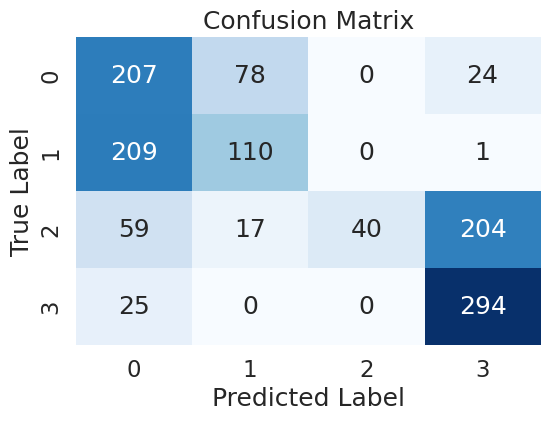

test acc:51.3407


In [ ]:
test_acc, confusion_mat, precision, recall, f1_score= test_combined(combined_model,tt_loader_all, config.device)
print(f"test acc:{test_acc:.4f}")

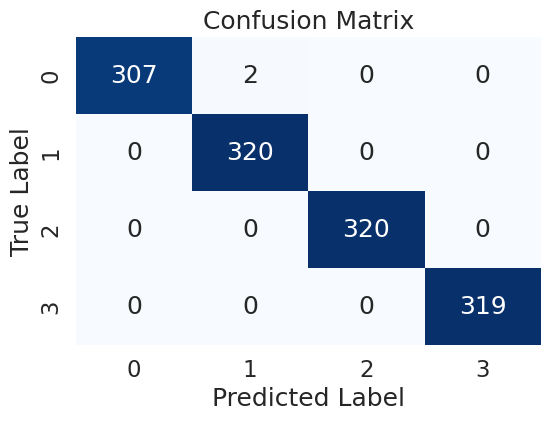

test acc:99.8423


In [ ]:
# del combined_model
combined_model =  CombinedFCModel().to(config.device)
ckpt = torch.load('models/img_ensemble.pth', map_location='cpu')  # Load your best model
combined_model.load_state_dict(ckpt)
test_acc, confusion_mat, precision, recall, f1_score= test_combined(combined_model,tt_loader_all, config.device)
print(f"test acc:{test_acc:.4f}")

In [ ]:
combined_model

CombinedFCModel(
  (transformer): TransformerModel(
    (encoder): Linear(in_features=7, out_features=64, bias=True)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Linear(in_features=64, out_feat

In [29]:
precision, recall, f1_score

(array([1.        , 0.99378882, 1.        , 1.        ]),
 array([0.99352751, 1.        , 1.        , 1.        ]),
 array([0.99675325, 0.99688474, 1.        , 1.        ]))

## Explainable

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model.to(config.device)
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        self.model.zero_grad()
        output = self.model(input_image)
        loss = output[0, target_class]
        loss.backward()
        
        gradients = self.gradients.detach()
        activations = self.activations.detach()
        
        weights = torch.mean(gradients, dim=[0, 2, 3, 4]).to(config.device)
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(config.device)
        
        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :, :]
        
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam) #normalize
        # cam = cam.cpu().numpy()
        return cam


In [125]:
sensor,img ,labels= next(iter(tt_loader_all))
print(img.shape)
print(sensor.shape)

torch.Size([16, 12, 3, 56, 56])
torch.Size([16, 12, 7])


In [117]:
# 假設modelA和modelB的特徵圖層名稱分別為"features"和"layer2"
target_layerA = combined_model.vgg.modelA.features[2]  # MaxPool3d layer for modelA
target_layerB = combined_model.vgg.modelB.layer2[1].conv2  # conv2 layer of the second BasicBlock in layer2 for modelB

gradcamA = GradCAM3D(combined_model.vgg.modelA, target_layerA)
gradcamB = GradCAM3D(combined_model.vgg.modelB, target_layerB)

# 生成Grad-CAM圖像
input_image = img
input_image=input_image.transpose(1,2)
# print(input_image.shape)
input_image = input_image.to(config.device) 


with torch.no_grad():
    combined_model.eval()
    output = combined_model.vgg(input_image)
    # print(output)
    target_classA = output.argmax(dim=1)
    output = combined_model.vgg(input_image)
    target_classB = output.argmax(dim=1)

target_classA = target_classA[0].item()  # 假设我们只处理一个样本
target_classB = target_classB[0].item()  # 假设我们只处理一个样本

camA = gradcamA.generate_cam(input_image, target_classA)
camB = gradcamB.generate_cam(input_image, target_classB)

camA=torch.mean(camA,dim=0)
camA=camA.cpu().numpy()

camB=torch.mean(camB,dim=0)
camB=camB.cpu().numpy()


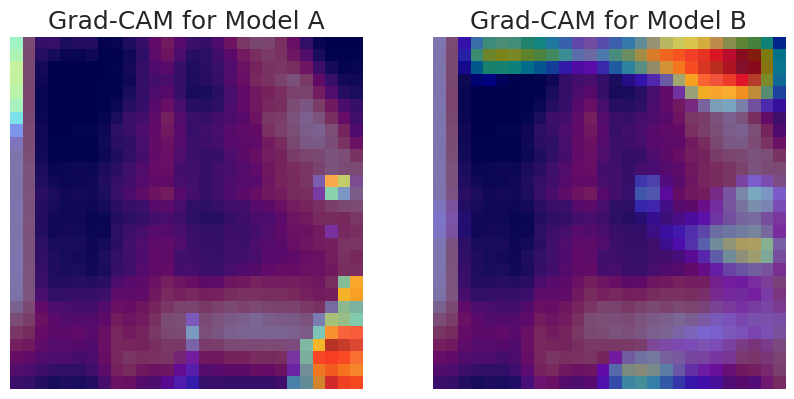

In [113]:
import matplotlib.pyplot as plt

def visualize_cam_3d(cam, image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # 取中间切片可视化
    middle_slice = cam.shape[0] // 2

    ax.imshow(image[0, 0, middle_slice].cpu().numpy(), alpha=0.5)
    ax.imshow(cam[middle_slice], cmap='jet', alpha=0.5)
    ax.axis('off')

# 假设 input_image 是已经处理过的图像张量
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
visualize_cam_3d(camA, input_image, ax=axes[0])
axes[0].set_title('Grad-CAM for Model A')
visualize_cam_3d(camB, input_image, ax=axes[1])
axes[1].set_title('Grad-CAM for Model B')
plt.show()


In [27]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# 假設你的 Transformer 模型為 combined_model.transformer
transformer_model = combined_model.transformer

transformer_model=transformer_model.to(config.device)
sensor=sensor.to(config.device)
# 將模型轉換為 eval 模式
transformer_model.eval()

# 如果模型的輸出經過了 softmax，則需要在計算 SHAP 值之前去除 softmax
def model_forward(input_data):
    output = transformer_model(input_data)
    return output

# 創建一個 PyTorch Deep Explainer
explainer = shap.GradientExplainer(transformer_model, sensor)


# 選擇一個樣本進行解釋（例如第一個樣本）
sample_data = sensor[:10]

# 計算 SHAP 值
shap_values = explainer.shap_values(sample_data)

# # 手動計算基線值（預期值）
# background_data = sensor[:10] # 使用前 100 個樣本作為背景數據
# baseline_value = model_forward(background_data).mean(0).cpu().detach().numpy()

# # 可視化 SHAP 值
# shap.initjs()
# # 将 SHAP 值转换为张量，并确保在同一设备上
# shap_values_tensor = [torch.tensor(sv).to(config.device) for sv in shap_values]

# # 将 SHAP 值转换为 NumPy 数组
# shap_values_np = [sv.cpu().detach().numpy() for sv in shap_values_tensor]

# # 确定是否为多输出模型
# if isinstance(baseline_value, np.ndarray) and baseline_value.ndim > 0:
#     # 多输出模型，选择第一个输出
#     shap.summary_plot(baseline_value[0], shap_values_np[0][0], feature_names=[f"Feature {i}" for i in range(sensor.shape[2])])
# else:
#     # 单输出模型
#     shap.summary_plot(baseline_value, shap_values_np[0][0], feature_names=[f"Feature {i}" for i in range(sensor.shape[2])])
    
    

In [26]:
print('Shape of shap_values:', np.shape(shap_values))

Shape of shap_values: (4, 1, 12, 7)


In [185]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# 假设你的 Transformer 模型为 combined_model.transformer
transformer_model = combined_model.transformer

transformer_model.to(config.device)
sensor_data = sensor.to(config.device)



In [186]:
transformer_model

TransformerModel(
  (encoder): Linear(in_features=7, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=4, bias=True)
)